# 패키지 설치

In [102]:
!pip install git+https://github.com/ssut/py-hanspell.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-inxnpn29
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-inxnpn29


# 실행환경 설정
- google colab
- local

In [103]:
IDE = "google_colab"
# IDE = "local"

# 데이터 준비

In [104]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import re
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
if IDE == "local":
    csv_path = r"G:\내 드라이브\0. 인공지능 학습\아이펠 대전 3기\2. Exploration 수업\코드\11강\ChatbotData.csv"
elif IDE == "google_colab":
    from google.colab import drive
    drive.mount('/gdrive')
    
    csv_path = '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/11강/ChatbotData.csv'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [106]:
chatbot_data = pd.read_csv(csv_path)

# EDA

In [107]:
chatbot_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [108]:
chatbot_data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [109]:
chatbot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [110]:
chatbot_data.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 369.5+ KB


- Question, Answer, Label 등의 데이터로 구성
- 데이터 개수 : 11823 개
- null 데이터 개수 : 0 개
- 중복 데이터 개수 : 0 개

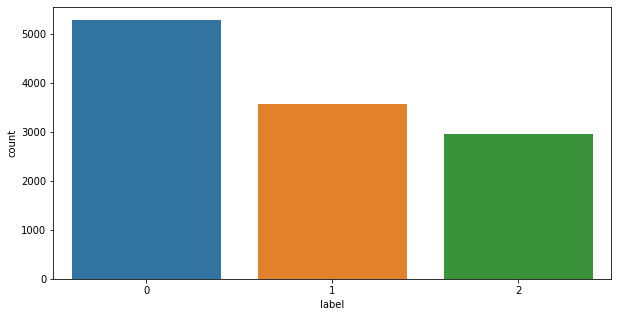

In [111]:
plt.figure(figsize=(10, 5))
sns.countplot(x="label", data=chatbot_data)

- 레이블 정보
    - 일상다반사 : 0
    - 이별(부정) : 1
    - 사랑(긍정) : 2
- 레이블 데이터 사이에 불균형 존재

# 데이터 전처리
- 특수문자 전처리
    - 데이터셋을 살펴본 결과 정제된 데이터셋임을 확인함
    - 따라서 큰 전처리 과정은 필요없음
    - 영어가 혼합된 문장일 경우 단어를 대문자로 변경
    - 모든 경우 완성된 문장을 사용하기 때문에 '.' 은 삭제
    - 질문을 뜻하는 '?'를 제외한 모든 특수문자 삭제
- 한국어 전처리 패키지를 사용하여 전처리 수행
    - Py-Hanspell 패키지 사용
        - 네이버 한글 맞춤법 검사기를 바탕으로 만들어진 패키지
        - 맞춤법이 틀린 문장, 띄어쓰기 등 수정
- 불용어 제거
    - 자연스러운 문장을 생성하기 위해 조사, 의미없는 단어 모두 사용
    - 따라서 불용어 제거 없이 사용

## 특수문자 전처리

In [112]:
chatbot_data.head(5)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [113]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 영어 대문자로 변경
    sentence = sentence.upper().strip()

    # (가-힣, a-z, A-Z, 0-9, "?")를 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

In [114]:
raw_Q_corpus = []
raw_A_corpus = []
symbol_removed_Q_corpus = []
symbol_removed_A_corpus = []
labels = []

for i in tqdm_notebook(range(chatbot_data.shape[0])):
    raw_Q_corpus.append(chatbot_data.iloc[i, 0])
    raw_A_corpus.append(chatbot_data.iloc[i, 1])
    symbol_removed_Q_corpus.append(preprocess_sentence(chatbot_data.iloc[i, 0]))
    symbol_removed_A_corpus.append(preprocess_sentence(chatbot_data.iloc[i, 1]))
    labels.append(chatbot_data.iloc[i, 2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/11823 [00:00<?, ?it/s]

In [115]:
print("Question 전처리 전")
print(raw_Q_corpus[:20])

print("\nQuestion 전처리 후")
print(symbol_removed_Q_corpus[:20])

Question 전처리 전
['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네', 'SD카드 망가졌어', 'SD카드 안돼', 'SNS 맞팔 왜 안하지ㅠㅠ', 'SNS 시간낭비인 거 아는데 매일 하는 중', 'SNS 시간낭비인데 자꾸 보게됨', 'SNS보면 나만 빼고 다 행복해보여', '가끔 궁금해', '가끔 뭐하는지 궁금해', '가끔은 혼자인게 좋다', '가난한 자의 설움', '가만 있어도 땀난다', '가상화폐 쫄딱 망함', '가스불 켜고 나갔어', '가스불 켜놓고 나온거 같아', '가스비 너무 많이 나왔다.']

Question 전처리 후
['12시 땡', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네', 'SD카드 망가졌어', 'SD카드 안돼', 'SNS 맞팔 왜 안하지', 'SNS 시간낭비인 거 아는데 매일 하는 중', 'SNS 시간낭비인데 자꾸 보게됨', 'SNS보면 나만 빼고 다 행복해보여', '가끔 궁금해', '가끔 뭐하는지 궁금해', '가끔은 혼자인게 좋다', '가난한 자의 설움', '가만 있어도 땀난다', '가상화폐 쫄딱 망함', '가스불 켜고 나갔어', '가스불 켜놓고 나온거 같아', '가스비 너무 많이 나왔다']


In [116]:
print("Answer 전처리 전")
print(raw_A_corpus[:20])

print("\nAnswer 전처리 후")
print(symbol_removed_A_corpus[:20])

Answer 전처리 전
['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.', '다시 새로 사는 게 마음 편해요.', '다시 새로 사는 게 마음 편해요.', '잘 모르고 있을 수도 있어요.', '시간을 정하고 해보세요.', '시간을 정하고 해보세요.', '자랑하는 자리니까요.', '그 사람도 그럴 거예요.', '그 사람도 그럴 거예요.', '혼자를 즐기세요.', '돈은 다시 들어올 거예요.', '땀을 식혀주세요.', '어서 잊고 새출발 하세요.', '빨리 집에 돌아가서 끄고 나오세요.', '빨리 집에 돌아가서 끄고 나오세요.', '다음 달에는 더 절약해봐요.']

Answer 전처리 후
['하루가 또 가네요', '위로해 드립니다', '여행은 언제나 좋죠', '여행은 언제나 좋죠', '눈살이 찌푸려지죠', '다시 새로 사는 게 마음 편해요', '다시 새로 사는 게 마음 편해요', '잘 모르고 있을 수도 있어요', '시간을 정하고 해보세요', '시간을 정하고 해보세요', '자랑하는 자리니까요', '그 사람도 그럴 거예요', '그 사람도 그럴 거예요', '혼자를 즐기세요', '돈은 다시 들어올 거예요', '땀을 식혀주세요', '어서 잊고 새출발 하세요', '빨리 집에 돌아가서 끄고 나오세요', '빨리 집에 돌아가서 끄고 나오세요', '다음 달에는 더 절약해봐요']


## Py-Hanspell 패키지 사용
- 띄어쓰기, 맞춤법 개선

In [ ]:
from hanspell import spell_checker

preprocessed_Q_corpus = []
preprocessed_A_corpus = []

for i in tqdm_notebook(range(len(symbol_removed_Q_corpus))):
    question = spell_checker.check(symbol_removed_Q_corpus[i])
    question = question.checked
    preprocessed_Q_corpus.append(question)
    
    answer = spell_checker.check(symbol_removed_A_corpus[i])
    answer = answer.checked
    preprocessed_A_corpus.append(answer)

In [ ]:
print("Question 전처리 전")
print(symbol_removed_Q_corpus[:20])

print("\nQuestion 전처리 후")
print(preprocessed_Q_corpus[:20])

In [ ]:
print("Answer 전처리 전")
print(symbol_removed_A_corpus[:20])

print("\nAnswer 전처리 후")
print(preprocessed_A_corpus[:20])

- 정제된 문장을 사용해서 그런지 큰 변화는 발생하지 않음
- 그냥 맞춤법 및 띄어쓰기 개선 안한 문장 사용하겠음

In [118]:
preprocessed_Q_corpus = []
preprocessed_A_corpus = []

for i in tqdm_notebook(range(len(symbol_removed_Q_corpus))):
    preprocessed_Q_corpus.append(symbol_removed_Q_corpus[i])
    preprocessed_A_corpus.append(symbol_removed_A_corpus[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/11823 [00:00<?, ?it/s]

# 토큰화 및 단어장 생성

In [119]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(preprocessed_Q_corpus + preprocessed_A_corpus, target_vocab_size=2**13)

In [120]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [121]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8180]
END_TOKEN의 번호 : [8181]


In [122]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8182


In [123]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(preprocessed_Q_corpus[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(preprocessed_A_corpus[21])))

정수 인코딩 후의 21번째 질문 샘플: [5765, 607, 2486, 4159]
정수 인코딩 후의 21번째 답변 샘플: [2354, 7520, 5, 6274, 103]


# 패딩

In [128]:
def show_sentence_len(data):
    sentence_len_cnt = []
    for sen in data:
        sentence_len_cnt.append(len(sen))

    # 문장 길이의 유니크 알아내기
    columns = np.unique(np.array(sentence_len_cnt))
    columns

    # 문장 길이 데이터프레임 생성
    # 데이터 입력 부분에 [] 넣어줘야 데이터가 가로로 들어감
    sentence_len_df = pd.DataFrame(data=[np.zeros_like(columns)], columns=columns)

    # 데이터 추가
    for sen in tqdm_notebook(data):
        sen_len = len(sen)
        sentence_len_df[sen_len] += 1

    # 빈 데이터프레임 생성
    a = pd.DataFrame(data=[np.zeros_like(columns)], columns=columns)
    sentence_len_df = pd.concat([sentence_len_df, a], axis=0)
    # sentence_len_df

    # 문장 길이 누적 데이터 추가
    cnt = 0
    for i in range(len(columns)):
        sentence_len_df.iloc[1, i] = sentence_len_df.iloc[0, i] + cnt
        cnt = sentence_len_df.iloc[1, i]
    # sentence_len_df

    # 백분율로 변경
    sentence_len_percent = sentence_len_df.iloc[1, :].apply(lambda x: 100 * x / sentence_len_df.iloc[1, -1])

    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(15, 7))
    ax2 = ax1.twinx()

    c1 = sns.histplot(ax = ax1, data = sentence_len_cnt, bins=10, color = 'm')
    c2 = sns.lineplot(ax = ax2, data = sentence_len_percent, color = 'blue')

    plt.grid(True)

    ax1.set_ylabel('sentence length count')
    ax2.set_ylabel('percentage')

    ax1.set_xlabel("sentence length")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/11823 [00:00<?, ?it/s]

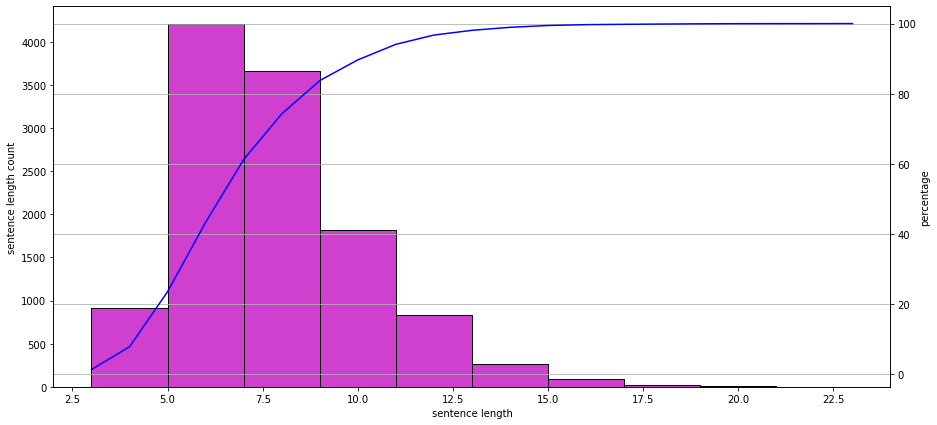

In [129]:
Q = []
for sen in preprocessed_Q_corpus:
    sen = START_TOKEN + tokenizer.encode(sen) + END_TOKEN
    Q.append(sen)

show_sentence_len(Q)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/11823 [00:00<?, ?it/s]

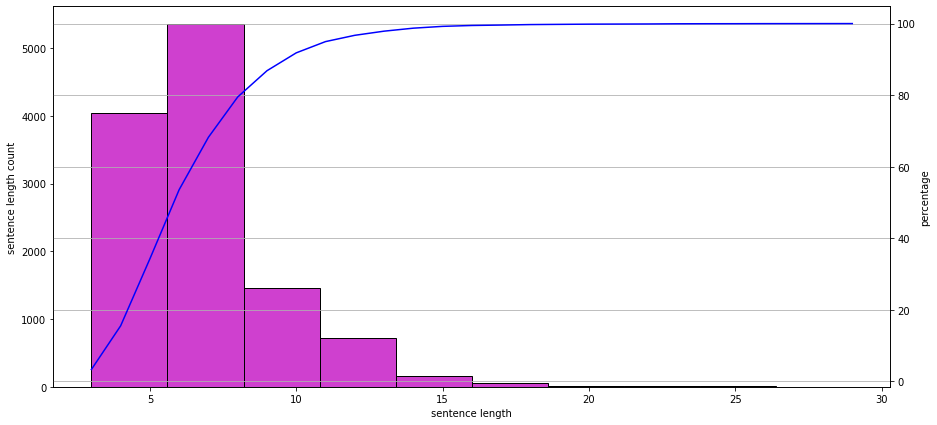

In [130]:
A = []
for sen in preprocessed_A_corpus:
    sen = START_TOKEN + tokenizer.encode(sen) + END_TOKEN
    A.append(sen)

show_sentence_len(A)

- Question과 Answer 모두에서 문장 길이를 10으로 제한할 경우 데이터의 90% 이상을 활용 가능
- Question과 Answer 모두에서 문장 길이를 15으로 제한할 경우 데이터의 99% 이상을 활용 가능


In [131]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 10
print(MAX_LENGTH)

10


- SOS 및 EOS 추가를 고려하여 문장 최대 길이를 10으로 설정

In [133]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [134]:
questions, answers = tokenize_and_filter(preprocessed_Q_corpus, preprocessed_A_corpus)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8182
필터링 후의 질문 샘플 개수: 9797
필터링 후의 답변 샘플 개수: 9797


# 데이터 분리

In [135]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(questions, answers, random_state=0, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=0, test_size=0.25)

- train/valid/test 비율 60:20:20로 설정
- 전체 데이터를 train/test 비율 80:20로 분리
- train 데이터를 train/valid 비율 75:25로 분리

In [136]:
def make_datasets(questions, answers):
    BATCH_SIZE = 64
    BUFFER_SIZE = 20000

    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'inputs': questions,
            'dec_inputs': answers[:, :-1]
        },
        {
            'outputs': answers[:, 1:]
        },
    ))

    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [137]:
train_dataset = make_datasets(x_train, y_train)
valid_dataset = make_datasets(x_valid, y_valid)
test_dataset = make_datasets(x_test, y_test)

# Positinal Encoding 함수 생성

In [138]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

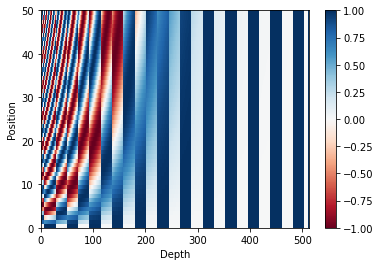

In [139]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Scaled dot product attention 함수 생성

In [140]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

# Multi head attention 함수 생성

In [141]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))

        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0] # 단어 길이를 왜 헷갈리게 batch_size라고 표현하니

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)

        return outputs


In [142]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)

    # (batch_size, 1, 1, sequence_length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [143]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)

    return tf.maximum(look_ahead_mask, padding_mask)

# Encoder 함수 생성

In [144]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [145]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# Decoder 함수 생성

In [146]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttention(d_model, num_heads, name="attentions_1")(
        inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(d_model, num_heads, name="attentions_2")(
        inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [147]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 모델 설정

In [148]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [149]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3148800     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

# 손실 함수 설정

In [150]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

# 학습률 설정

In [151]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

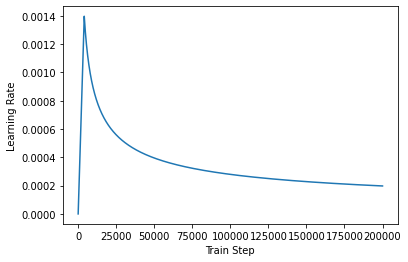

In [152]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# 학습 진행

In [153]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [154]:
epochs = 100

In [155]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [156]:
save_path = '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/11강/model_best.h5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_dataset,
                    epochs=epochs, 
                    validation_data=(valid_dataset), 
                    callbacks=[es, mc],
                    verbose=1)

Epoch 1/100
91/92 [============================>.] - ETA: 0s - loss: 5.0518 - accuracy: 0.0676WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 11s 53ms/step - loss: 5.0483 - accuracy: 0.0680 - val_loss: 4.7839 - val_accuracy: 0.1111
Epoch 2/100
91/92 [============================>.] - ETA: 0s - loss: 4.6375 - accuracy: 0.1111WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 34ms/step - loss: 4.6409 - accuracy: 0.1111 - val_loss: 4.4704 - val_accuracy: 0.1111
Epoch 3/100
91/92 [============================>.] - ETA: 0s - loss: 4.2886 - accuracy: 0.1111WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 33ms/step - loss: 4.2873 - accuracy: 0.1111 - val_loss: 4.1491 - val_accuracy: 0.1111
Epoch 4/100
91/92 [============================>.] - ETA: 0s - loss: 3.9792 - accuracy: 0.1111WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 33ms/step - loss: 3.9739 - accuracy: 0.1111 - val_loss: 3.9441 - val_accuracy: 0.1111
Epoch 5/100
91/92 [============================>.] - ETA: 0s - loss: 3.7807 - accuracy: 0.1112WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 34ms/step - loss: 3.7846 - accuracy: 0.1112 - val_loss: 3.8113 - val_accuracy: 0.1133
Epoch 6/100
91/92 [============================>.] - ETA: 0s - loss: 3.6091 - accuracy: 0.1151WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 33ms/step - loss: 3.6101 - accuracy: 0.1151 - val_loss: 3.6793 - val_accuracy: 0.1191
Epoch 7/100
91/92 [============================>.] - ETA: 0s - loss: 3.4394 - accuracy: 0.1235WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 34ms/step - loss: 3.4392 - accuracy: 0.1235 - val_loss: 3.5716 - val_accuracy: 0.1294
Epoch 8/100
91/92 [============================>.] - ETA: 0s - loss: 3.2838 - accuracy: 0.1321WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 34ms/step - loss: 3.2838 - accuracy: 0.1321 - val_loss: 3.4857 - val_accuracy: 0.1352
Epoch 9/100
92/92 [==============================] - ETA: 0s - loss: 3.1270 - accuracy: 0.1427WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 4s 38ms/step - loss: 3.1270 - accuracy: 0.1427 - val_loss: 3.4333 - val_accuracy: 0.1401
Epoch 10/100
91/92 [============================>.] - ETA: 0s - loss: 2.9615 - accuracy: 0.1559WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 33ms/step - loss: 2.9636 - accuracy: 0.1559 - val_loss: 3.3558 - val_accuracy: 0.1513
Epoch 11/100
91/92 [============================>.] - ETA: 0s - loss: 2.7853 - accuracy: 0.1768WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 33ms/step - loss: 2.7862 - accuracy: 0.1768 - val_loss: 3.3120 - val_accuracy: 0.1586
Epoch 12/100
91/92 [============================>.] - ETA: 0s - loss: 2.5924 - accuracy: 0.2000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 33ms/step - loss: 2.5929 - accuracy: 0.2002 - val_loss: 3.2584 - val_accuracy: 0.1674
Epoch 13/100
91/92 [============================>.] - ETA: 0s - loss: 2.3862 - accuracy: 0.2262WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 34ms/step - loss: 2.3877 - accuracy: 0.2261 - val_loss: 3.2389 - val_accuracy: 0.1750
Epoch 14/100
91/92 [============================>.] - ETA: 0s - loss: 2.1690 - accuracy: 0.2545WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 33ms/step - loss: 2.1673 - accuracy: 0.2544 - val_loss: 3.1305 - val_accuracy: 0.1871
Epoch 15/100
91/92 [============================>.] - ETA: 0s - loss: 1.9411 - accuracy: 0.2836WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 34ms/step - loss: 1.9409 - accuracy: 0.2837 - val_loss: 3.0672 - val_accuracy: 0.1965
Epoch 16/100
91/92 [============================>.] - ETA: 0s - loss: 1.7099 - accuracy: 0.3163WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 33ms/step - loss: 1.7102 - accuracy: 0.3161 - val_loss: 3.0347 - val_accuracy: 0.2038
Epoch 17/100
91/92 [============================>.] - ETA: 0s - loss: 1.4791 - accuracy: 0.3496WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 36ms/step - loss: 1.4804 - accuracy: 0.3495 - val_loss: 2.9890 - val_accuracy: 0.2161
Epoch 18/100
91/92 [============================>.] - ETA: 0s - loss: 1.2579 - accuracy: 0.3830WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 33ms/step - loss: 1.2589 - accuracy: 0.3828 - val_loss: 3.0018 - val_accuracy: 0.2208
Epoch 19/100
91/92 [============================>.] - ETA: 0s - loss: 1.0432 - accuracy: 0.4177WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 34ms/step - loss: 1.0438 - accuracy: 0.4175 - val_loss: 2.9937 - val_accuracy: 0.2272
Epoch 20/100
92/92 [==============================] - ETA: 0s - loss: 0.8437 - accuracy: 0.4493WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 4s 45ms/step - loss: 0.8437 - accuracy: 0.4493 - val_loss: 2.9854 - val_accuracy: 0.2343
Epoch 21/100
92/92 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.4818WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 4s 41ms/step - loss: 0.6617 - accuracy: 0.4818 - val_loss: 3.0236 - val_accuracy: 0.2370
Epoch 22/100
92/92 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.5105WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 37ms/step - loss: 0.5007 - accuracy: 0.5105 - val_loss: 3.0319 - val_accuracy: 0.2434
Epoch 23/100
91/92 [============================>.] - ETA: 0s - loss: 0.3695 - accuracy: 0.5328WARNING:tensorflow:Can save best model only with val_acc available, skipping.


92/92 [==============================] - 3s 33ms/step - loss: 0.3698 - accuracy: 0.5329 - val_loss: 3.0670 - val_accuracy: 0.2487
Epoch 23: early stopping


# history 시각화

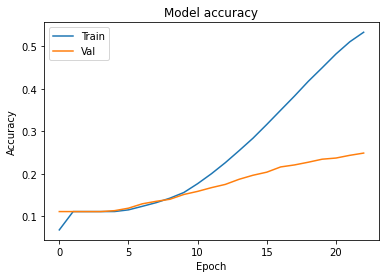

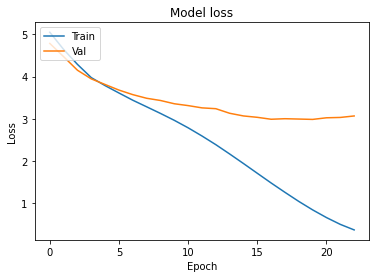

In [157]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 학습 결과 테스트

In [168]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=2)
print("test_loss: {0} ".format(round(test_loss, 2)))
print("test_accuracy: {0}".format(round(test_accuracy, 2)))

31/31 - 1s - loss: 3.1239 - accuracy: 0.2545 - 771ms/epoch - 25ms/step
test_loss: 3.12 
test_accuracy: 0.25


- 정확도는 25%로 그다지 높지 않음

In [184]:
def decoder_inference(sentence):
  sentence = tf.expand_dims(sentence, axis=0)
  
  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [185]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  return predicted_sentence

In [188]:
i = 0
for (question, answer) in zip(x_test, y_test):
    decode_sentence = []
    for sen in question:
        if sen == 8180:
            continue
        elif sen == 8181:
            break
        decode_sentence.append(sen)
    print("{}번째 문장".format(i))
    print('Test Dataset Question : {}'.format(tokenizer.decode(decode_sentence)))

    decode_sentence = []
    for sen in answer:
        if sen == 8180:
            continue
        elif sen == 8181:
            break
        decode_sentence.append(sen)
    print('Test Dataset Answer : {}'.format(tokenizer.decode(decode_sentence)))

    print('Predicted Answer by Model : {}'.format(sentence_generation(question)))
    print("\n")

    i += 1
    if i == 100:
        break

0번째 문장
Test Dataset Question : 딸기가 너무 먹고 싶어
Test Dataset Answer : 신선한 과일 좋죠
Predicted Answer by Model : 저도요


1번째 문장
Test Dataset Question : 군대 기다리면 부담스러워할까
Test Dataset Answer : 너무 걱정하지 마세요
Predicted Answer by Model : 끝은 눈에 보이지 않아 더 힘들죠


2번째 문장
Test Dataset Question : 어이가 없네
Test Dataset Answer : 한번 웃고 잊어버리세요
Predicted Answer by Model : 잊어버리세요


3번째 문장
Test Dataset Question : 사랑은 시간이 약인가?
Test Dataset Answer : 시간이 약인 경우가 많아요
Predicted Answer by Model : 시간이 참 빨리 흘러가네요


4번째 문장
Test Dataset Question : 엄마 말씀 안 들은거 후회돼
Test Dataset Answer : 지금이라도 효도하세요
Predicted Answer by Model : 사람은 외로운 동물이죠


5번째 문장
Test Dataset Question : 이별 3일째
Test Dataset Answer : 아직 많이 힘들겠어요
Predicted Answer by Model : 마음이 허전하신가봐요


6번째 문장
Test Dataset Question : 잊기가 힘듭니다
Test Dataset Answer : 충분히 힘들만하다고 생각해요
Predicted Answer by Model : 더 좋은 기회가 올 거예요


7번째 문장
Test Dataset Question : 너무 설레서 울렁거려
Test Dataset Answer : 부러워요 자연스러운 현상이에요
Predicted Answer by Model : 이젠 그녀를 놓아주세요


8번째 문장
Test Dataset Question : 다 맞춰주고 

- 100개의 테스트 데이터에 대하여 테스트 결과를 시각화함
- 모델이 예측한 결과가 실제 문장의 형태를 띄고 있음
- 낮은 확률로 질문에 대한 올바른 답변을 내놓는 경우가 있음
- 반대로 높은 확률로 문맥에 맞지 않는 답변을 내놓고 있음
- 아직 언어의 문맥까지 이해하기에는 모델이 너무 작은 듯 함